# Neural Networks

`torch.nn` 패키지를 통해 neural network를 만들 수 있다.

`nn` 패키지는 `autograd` 패키지에 많은 도움을 받으며 모델을 정의하고 Backpropagation을 한다. `nn.Module`은 layer들과 output을 뱉는 `forward(input)`이라는 메서드를 가진다.

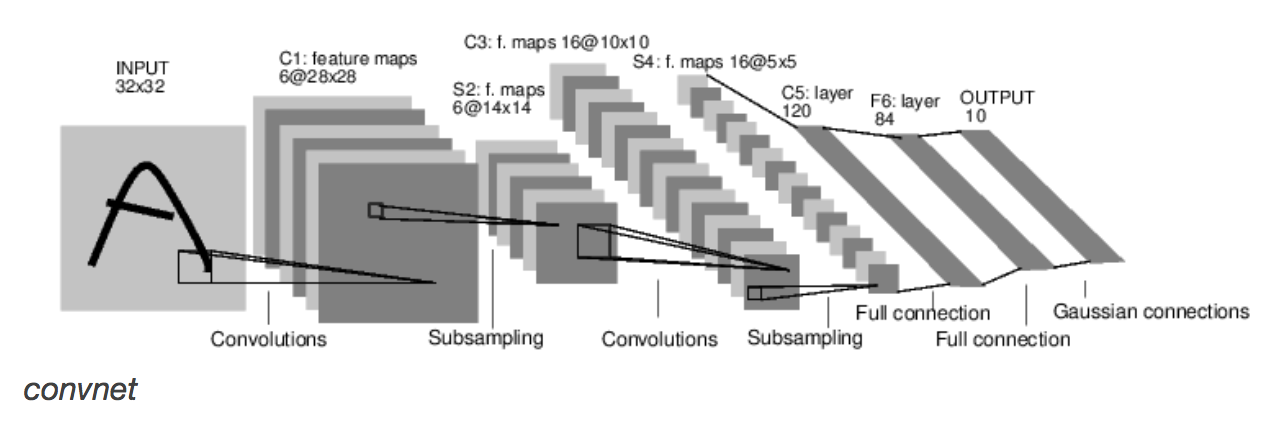

위 그림은 간단한 feed-forward 네트워크이다. 즉, 입력을 받아 layer에게 주고, 그 layer는 입력을 처리해서 다음 layer에게 넘겨주는 일을 반복하다가 마지막으로는 출력을 만드는 네트워크이다.

neural network를 훈련시키는 보통의 방법은 
  
1. learnable parameters(or weights)를 가지는 neural network를 정의한다.
2. dataset을 반복 입력시킨다.
3. neural network가 입력을 처리한다.
4. loss(=cost)를 계산한다.
5. Backpropagation(출력에서 입력으로 변화량을 계산해 보낸다.)
6. weight들을 새로 변경한다. (weight -= learning_rate * gradient)

## Define the network

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        # nn.Conv2d의 첫 번째 인자는 입력 이미지의 채널(한 픽셀의 feature의 수라고 봐도 된다.)
        # 두 번째 인자는 출력 이미지의 채널이고,
        # 세 번째 인자는 filter(=kernel)의 크기이다.
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # 위와 아래는 같은 의미이다. 즉 max pooling window가 정사각형이면 값 하나만 써도 된다.
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
net = Net()
print(net)

Net(
  (conv1): Conv2d (1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d (6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120)
  (fc2): Linear(in_features=120, out_features=84)
  (fc3): Linear(in_features=84, out_features=10)
)


`forward` 메서드를 정의하면 `backward` 메서드는 `autograd`를 이용해 자동으로 만들어진다. 그리고 `forward` 메서드 안에서는 어떤 Tensor 연산이라도 가능하다.

만들어진 model의 learnable parameter들은 `parameters`라는 메서드를 이용해 얻을 수 있다.

In [3]:
params = list(net.parameters())
print(len(params))
print(params[0].size()) # conv1의 가중치 값이 나온다

10
torch.Size([6, 1, 5, 5])


모델에 넣을 수 있는 입력은 `autograd.Variable`이어야 한다. 출력 또한 마찬가지다.

In [4]:
input = Variable(torch.randn(1, 1, 32, 32))
out = net(input)
print(out)

Variable containing:
-0.0898  0.0822 -0.0034  0.0449  0.1274 -0.0202  0.0698  0.0863 -0.0765  0.1187
[torch.FloatTensor of size 1x10]



모델이 가지고 있는 모든 weight들의 변화량을 저장하는 버퍼들을 0으로 초기화하고, 무작위의 변화량을 가지고 backpropagation을 한다.

In [5]:
net.zero_grad()
out.backward(torch.randn(1, 10))

`torch.nn`은 single sample이 아니라 mini-batch of samples만 지원한다. (입력하는 데이터 set이 1D이면 안 된다는 의미이다. 반드시 2D이상이어야 하고 반드시 첫 번째 차원(x.size[0])을 나타내는 값의 의미는 sample의 개수이어야 한다.) 
  
예를 들면, `nn.Conv2d`는 4D Tensor((nSamples, nChannels, Height, Width)를 크기로 갖는)를 입력으로 받는다.  
  
만약 single sample을 가지고 있다면 `unsqueeze` 메서드를 써서 가짜 batch 차원을 만들어준다.

## Loss Function

loss function은 (output, target)이라는 pair를 받아서 target과 output의 차이를 계산한다.

예시로 `nn.MSELoss` 메서드는 mean-squared error를 계산한다.

In [6]:
output = net(input)
target = Variable(torch.arange(1, 11)) # 진짜 target은 아니다.
cost_func = nn.MSELoss()

cost = cost_func(output, target)
print(cost)

Variable containing:
 38.0187
[torch.FloatTensor of size 1]



`cost`도 Variable이기 때문에 `backward` 메서드를 지원한다. 따라서 `cost.backward()`가 가능한데, 이는 cost에 대해서 모든 그래프를 미분해 변화량을 얻어내는 것이다. 그래프에 존재하는 모든 Variable은 `grad`라는 멤버 변수를 통해 변화량을 저장한다.

In [10]:
print(cost.grad_fn)
print(cost.grad_fn.next_functions[0][0])
print(cost.grad_fn.next_functions[0][0].next_functions[0][0])

## Backprop 

Backpropagation을 하기 위해서는 `loss.backward()`를 하면 된다. Backprop을 처음 한다면 반드시 `zero_grad` 메서드를 이용해서 Variable에 존재하는 변화량을 반드시 초기화 해야 한다. 안 하면 문제가 생긴다.

In [11]:
net.zero_grad()

print("conv1.bias.grad before backward")
print(net.conv1.bias.grad)

cost.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
Variable containing:
 0
 0
 0
 0
 0
 0
[torch.FloatTensor of size 6]

conv1.bias.grad after backward
Variable containing:
 0.0286
-0.0517
-0.1636
 0.0260
 0.0181
 0.0236
[torch.FloatTensor of size 6]



## Update the weights

가중치를 갱신하는 가장 간단한 방법은 Stochastic Gradient Descent(SGD)이다.  
  
`weight = weight - learning_rate * gradient`

neural network를 훈련시키기 위해서 다양한 함수들을 `torch.optim`에 모아 놓았으니 잘 써먹어 보자

In [12]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.01)

optimizer.zero_grad() # 처음 backprop을 하려면 반드시 초기화!
output = net(input)
cost = cost_func(output, target)
cost.backward()
optimizer.step()